# Imports

In [1]:
import torch
import os

import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torchvision.transforms import transforms
from torch.nn import Module, Conv2d, Linear, MaxPool2d, ReLU, Dropout, Sigmoid
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from datetime import date

# Data Directory Constants

In [2]:
ROOT_DIR = '.\\Data\\kaggle\\'
MODEL_DIR = '.\\models\\'
EVAL_DIR = '.\\Data\\kaggle\\evaluation\\'
SUB_DIR = '.\\submissions\\'

# Functions & Classes

In [3]:
###########################################################################################################################
# class LoadDataset()
# Used to create TensorDatasets.
# CreateDataset(data_files, labels) - Creates TensorDataset for Training, Testing, and Evaluation data to train the model
###########################################################################################################################
class LoadDataset():
    def __init__(self):
        self.data_files = []
        self.labels = []        

    def CreateDataset(self, data_files, labels):
        transform = transforms.Compose([
            transforms.RandomRotation(degrees = (0, 180)),
            transforms.RandomHorizontalFlip(p = 0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))
        ])
    
        for i in range(len(data_files)):
            data_pt = torch.load(data_files[i], weights_only = False)
            
            self.data_files.append(data_pt)
            self.labels.append(torch.tensor(labels[i], dtype = torch.long)) 
            
            transformed_pt = transform(data_pt)
            self.data_files.append(transformed_pt)
            self.labels.append(torch.tensor(labels[i], dtype = torch.long))
            
            
        data_tensor = torch.stack(self.data_files)
        label_tensor = torch.stack(self.labels)

        dataset = TensorDataset(data_tensor, label_tensor)
        return dataset

    def __len__(self):
        return len(self.data_files)

    def __getitem__(self, i):
        data = self.data_files[i]
        label = self.labels[i]
        
        return data, label

In [4]:
###########################################################
# class NeuralNetwork()
# A convolutional neural network using the Pytorch library
############################################################
class NeuralNetwork(Module):
    def __init__(self, num_channels):
        super(NeuralNetwork, self).__init__()

        self.conv1 = Conv2d(in_channels = num_channels, out_channels = 20, kernel_size = (5, 5))
        self.bn1 = nn.BatchNorm2d(20)
        self.relu1 = ReLU()
        self.maxpool1 = MaxPool2d(kernel_size = (2, 2), stride = (2, 2))

        self.conv2 = Conv2d(in_channels = 20, out_channels = 50, kernel_size = (5, 5))
        self.bn2 = nn.BatchNorm2d(50)
        self.relu2 = ReLU()
        self.maxpool2 = MaxPool2d(kernel_size = (2, 2), stride = (2, 2))
        self.dropout = Dropout(p = 0.3)

        self.fc1 = Linear(in_features = 1250, out_features = 800)
        self.relu3 = ReLU()
        self.fc2 = Linear(in_features = 800, out_features = 1)
        self.sigmoid = Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = torch.flatten(x, 1)
        #print(x.shape) - debugging
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.relu3(x)

        #print(x.shape) - debugging
        x = self.fc2(x)
        out = self.sigmoid(x)
        
        return out

In [5]:
#######################################################
# SaveModel(model)
# Used to save pytorch model as a pytorch tensor
######################################################
def SaveModel(model):
    curr_date = date.today()
    print('Saving model....')
    torch.save(model, MODEL_DIR + f'CNN-{curr_date}-Adam-CrossEntropy-Sigmoid.pth')
    print('Saviang model Completed...')

In [6]:
#########################################################
# Train(Epochs, model, dataloader_train, dataloader_test, opt)
# The train function to train the model
#########################################################
def Train(epochs, model, dataloader_train, dataloader_test, opt, device, criterion):
    print('Training Started.............')
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        model.to(device)

        for inputs, targets in dataloader_train:
            inputs, targets = inputs.to(device), targets.to(device)

            opt.zero_grad()
            outputs = model(inputs).squeeze()
            targets = targets.float()
            loss = criterion(outputs, targets)
            loss.backward()
            opt.step()

            train_loss += loss.item()
            predicted = (outputs > 0.5).float()
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

        train_accuracy = 100 * correct / total
        train_losses.append(train_loss / len(dataloader_train))
        
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, targets in dataloader_test:
                inputs_val, targets_val = inputs.to(device), targets.to(device)
                outputs_val = model(inputs_val).squeeze()
                targets_val = targets_val.float()
                loss = criterion(outputs_val, targets_val)
                val_loss += loss.item()

                predicted_val = (outputs_val > 0.5).float()
                total_val += targets_val.size(0)
                correct_val += (predicted_val == targets_val).sum().item()

        val_accuracy = 100 * correct_val / total_val
        val_losses.append(val_loss / len(dataloader_test))
        
        print(f"EPOCH: {epoch + 1} / {epochs} -- train loss: {train_loss / len(dataloader_train):.4f} train accuracy: {train_accuracy:.4f} val loss: {val_loss / len(dataloader_test):.4f} val accuracy: {val_accuracy:.4f}")
    
    print('Training Completed..........')

    # Display model performance
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.show()

# Data Preprocessing

In [7]:
#################################################################
# Load Data into 5 Lists (data, labels, evaluation)
#################################################################
print('Loading Data Started.............')
data_1_list = []
label_1_list = []
data_2_list = []
label_2_list = []
data_eval_list = []

for folder_name in os.listdir(ROOT_DIR):
    #print(folder_name) - debugging
    folder_path = os.path.join(ROOT_DIR, folder_name)
    #print(folder_path) - debugging
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        if folder_name == '1':
            data_1_list.append(file_path)
            label_1_list.append(0)
        if folder_name == '2':
            data_2_list.append(file_path)
            label_2_list.append(1)
        if folder_name == 'evaluation':
            data_eval_list.append(file_path)

# Load the lists into numpy arrays so that it can be stacked
# Used so that it can be a concatenation of data 1 & 2 and labels 1 & 2
data_1 = np.array(data_1_list)
label_1 = np.array(label_1_list)
data_2 = np.array(data_2_list)
label_2 = np.array(label_2_list)
data = np.hstack((data_1, data_2))
labels = np.hstack((label_1, label_2))

# Using sklearn's train_test_split to split the lists of data into datasets.
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size = 0.25, random_state = 1000)
    
# Create variables that will hold the data in TensorDatasets for the CNN
train_data = LoadDataset().CreateDataset(X_train, y_train)
val_data = LoadDataset().CreateDataset(X_test, y_test)

# Loads the train_data & val_data TensorDatasets into DataLoaders from pytorch for model training.
# This will be what is pasted to the model and trained on.
dataloader_train = DataLoader(train_data, batch_size = 2, shuffle = True)
dataloader_test = DataLoader(val_data, batch_size = 2, shuffle = True)
print('Loading Data Completed..............')

Loading Data Started.............
Loading Data Completed..............


In [8]:
print(len(X_train), len(y_train))

1272 1272


# Model Creation, Training & Metrics

Training Started.............
EPOCH: 1 / 75 -- train loss: 0.6680 train accuracy: 60.2594 val loss: 0.6918 val accuracy: 61.5566
EPOCH: 2 / 75 -- train loss: 0.6032 train accuracy: 66.1557 val loss: 0.5738 val accuracy: 66.0377
EPOCH: 3 / 75 -- train loss: 0.5905 train accuracy: 68.1604 val loss: 0.4958 val accuracy: 74.2925
EPOCH: 4 / 75 -- train loss: 0.5670 train accuracy: 70.2830 val loss: 0.8306 val accuracy: 58.6085
EPOCH: 5 / 75 -- train loss: 0.5486 train accuracy: 72.1698 val loss: 0.7123 val accuracy: 64.1509
EPOCH: 6 / 75 -- train loss: 0.5498 train accuracy: 71.5409 val loss: 0.5495 val accuracy: 75.2358
EPOCH: 7 / 75 -- train loss: 0.5079 train accuracy: 75.5503 val loss: 0.5137 val accuracy: 74.8821
EPOCH: 8 / 75 -- train loss: 0.4976 train accuracy: 75.8255 val loss: 0.5067 val accuracy: 76.2972
EPOCH: 9 / 75 -- train loss: 0.4717 train accuracy: 77.0047 val loss: 0.4959 val accuracy: 76.7689
EPOCH: 10 / 75 -- train loss: 0.4706 train accuracy: 76.7296 val loss: 0.6766 v

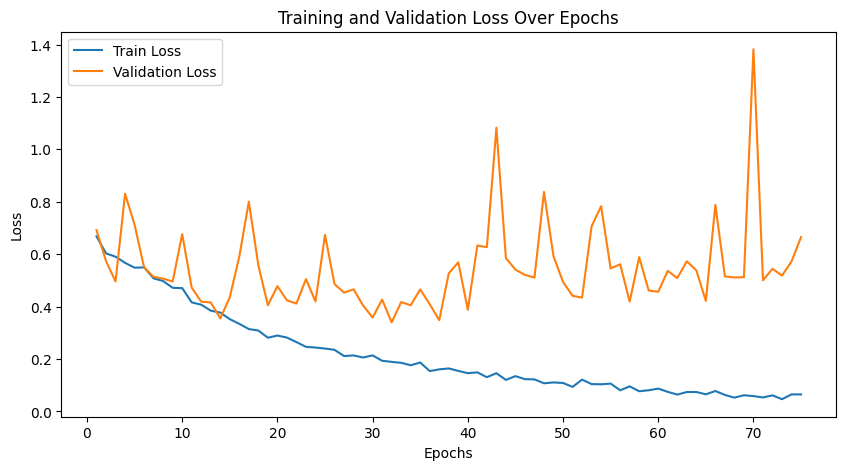

Saving model....
Saviang model Completed...


In [9]:
####################################
# CNN Model Training
###################################
model = NeuralNetwork(num_channels = 101)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
LR = 1e-4
OPTIMIZER = optim.Adam(model.parameters(), lr = LR)
EPOCHS = 75
CRITERION = nn.BCELoss()

Train(EPOCHS, model, dataloader_train, dataloader_test, OPTIMIZER, DEVICE, CRITERION)
SaveModel(model)

# Model Predictions on Unseen Data

In [10]:
################################################
# EVALUTION
# Loading evaluation data into DataLoader
################################################
eval_data = []

for file in data_eval_list:
    pt_data = torch.load(file, weights_only = False)
    eval_data.append(pt_data)
    
X_test = DataLoader(eval_data, shuffle = False)


######################################################
# Uncomment below to display predicted values
######################################################

print('Predicting validation set......')
all_predictions = []
model.to(DEVICE)
model.eval()

with torch.no_grad():
    for inputs in X_test:
        inputs = inputs.to(DEVICE)
        outputs = model(inputs).squeeze()
        predicted = (outputs > 0.5).float()
        all_predictions.extend(predicted.cpu().numpy().flatten())

print('All validation set predictions completed.....')        
print("Predictions:", all_predictions)


############################################################
# Uncomment below to create CSV and test accuracy on Kaggle
############################################################

pred_list = []
curr_date = date.today()
for pred in all_predictions:
    if pred == 0:
        pred_list.append(1)
    if pred == 1:
        pred_list.append(2)
    
eval_id_files = []
for file in os.listdir(EVAL_DIR):
    eval_id_files.append(file)

file_path = os.path.join(SUB_DIR, f'Agri_submission-BCE-{curr_date}-pc.csv')
sub_df = pd.DataFrame({'Id': eval_id_files, 'Category': pred_list})
sub_df.to_csv(file_path, index = False)


Predicting validation set......
All validation set predictions completed.....
Predictions: [1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0]
